# Continuous Control


### 1. Imports

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md), [NumPy](http://www.numpy.org/), [Pandas](https://pandas.pydata.org/), and [Matplotlib](https://matplotlib.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
from ppo_agent import Agent
import matplotlib.pyplot as plt
from typing import List
import pandas as pd
import torch

### 2. Instantiate the Environment and Agent and Explore the State and Action Spaces

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
# Load environment
env = UnityEnvironment(file_name="Reacher.app")

# Get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

# Instantiate the PPO agent
agent = Agent(env)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Train the Agent with PPO

In [3]:
def ppo(agent: Agent, solution_score: float = 30, n_episodes: int = 1000) -> List[float]:
    """ Train the PPO agent.

    :param agent: agent to be trained
    :param solution_score: score at which agent's environment is considered to be solved
    :param n_episodes: maximum number of episodes for which to train the agent
    :return: list of agent's scores for all episodes of training
    """

    all_scores = []  # List of all scores collected in training
    latest_scores = deque(maxlen=100)  # Deque of 100 most recent scores to determine if environment is solved
    for i in range(n_episodes):
        score = agent.train_for_episode()  # Train the agent for one episode and return the agent's score for the episode
        latest_scores.append(score)  # Store score
        all_scores.append(score)  # Store score

        # Print status updates
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(latest_scores)), end="")
        if i % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(latest_scores)))

        # Notify when environment is solved and save agent model parameters and score
        if np.mean(latest_scores) >= solution_score:
            print("\nEnvironment solved in {} episodes".format(i + 1))
            
            # Save local model weights to solution_actor.pth and solution_critic.pth
            agent.save()  
            
            # Save scores
            np.save('scores.npy', np.array(all_scores))
            break

    return all_scores

scores = ppo(agent)



Episode 0	Average Score: 0.26
Episode 100	Average Score: 6.63
Episode 200	Average Score: 23.34
Episode 267	Average Score: 30.02
Environment solved in 268 episodes


### 4. Plot the Score

<IPython.core.display.Javascript object>


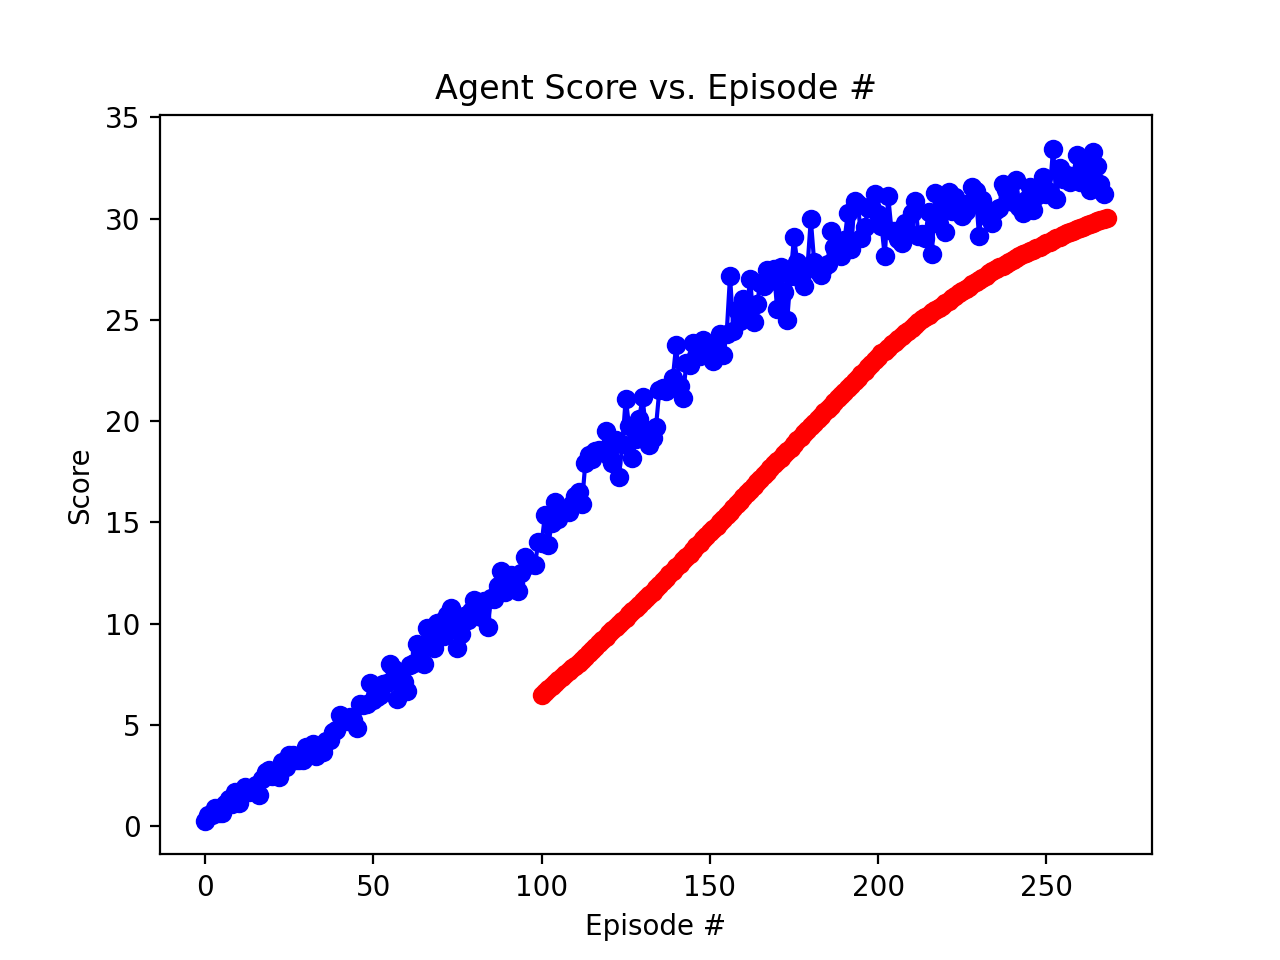

In [5]:
%matplotlib notebook

scores = np.load('scores.npy')

# Calculate rolling average of scores over specified window of episodes
window = 100
scores_w = pd.Series(scores).rolling(window=window).mean().iloc[window - 1:].values

# Plot all scores and rolling average of scores
plt.figure()
plt.plot(scores, color='b', marker='o', label='All Scores')
plt.plot(np.arange(len(scores_w)) + window, scores_w, color='r', marker='o', label='Average of Last {} Scores'.format(window))
plt.title('Agent Score vs. Episode #')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch the Trained Agent

Load the trained weights from `solution_actor.pth` and `solution_critic.pth` to watch the trained agent

In [3]:
agent.load('solution.pth')

In [4]:
n_episodes = 1

for _ in range(n_episodes):
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = torch.from_numpy(env_info.vector_observations).float()  # get the current state (for each agent)
    scores = np.zeros((num_agents))
    while True:
        actions = agent.act(states)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        states = torch.from_numpy(env_info.vector_observations).float()        # get next state (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += np.array(env_info.rewards)                        # update the score (for each agent)
        if np.any(dones):                                  # reset environment
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 32.34099927712232
Total score (averaged over agents) this episode: 32.34249927708879
Total score (averaged over agents) this episode: 33.39799925349653
Total score (averaged over agents) this episode: 31.648999292589725
Total score (averaged over agents) this episode: 31.456499296892435
Total score (averaged over agents) this episode: 31.78399928957224
Total score (averaged over agents) this episode: 31.680499291885646
Total score (averaged over agents) this episode: 33.052499261219054
Total score (averaged over agents) this episode: 33.08649926045909


### 6. Close environment 

In [5]:
env.close()
            